#**Машинное обучение ИБ-2024**

#**Домашнее задание 3.**
#Классификация текстов, методы обучения без учителя.

**Все выводы ячеек вашей сданной работы должны оставаться в сданном ноутбуке, результаты должны быть видны. В противном случае 0 за задание!**

## Классификация текстов.

В этой части домашней работы Вам требуется реализовать полный пайплайн работы с текстами и моделями машинного обучения. От предобработки до запуска обучения моделей для задачи классификации.

**Задачи**:
1. Предобработка - Вам необходимо в представленных текстах избавиться от пунктуации, чисел и стоп-слов (nltk stopwords), привести тексты к нижнему регистру.
2. Сделать на Вашем корпусе очищенных текстов Лемматизацию или Стемминг. При этом словестно пояснить, что делает метод.
3. Разбить полученный датасет на train и test выборки в отношении 4:1
4. Привести ваши тексты из датасета к векторному формату. Тут необходимо попробовать два метода, разобранных на семинаре: Bag of words и TF-IDF. При этом словестно пояснить, что делает метод.
5. Провести кросс-валидация на подбор гиперпараметров моделей (GridSearchCV) и обучить модели: Логистическая регрессия, Random Forest, Gradient Boosting из CatBoost или XGBoost или LightGBM. (В данном задании не стоит "упарываться" в подбор гиперпараметров и считать каждую модель по 10 часов, покажите в коде, что Вы перебирали по сетке 2-3 гиперпараметра в разумном по времени интервале).
6. Замерьте метрики accuracy, precision, recall, F1-Score, ROC-AUC. Постройте ConfusionMatrix, сделайте анализ решения.

Все пункты задания весят по 1 Баллу. То есть за данный раздел можно получить максимум 6 Баллов.

In [ ]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """Предобработка текста: приведение к нижнему регистру, удаление стоп-слов и пунктуации, лемматизация"""
    # Приводим текст к нижнему регистру
    text = text.lower()

    # Убираем пунктуацию и числа
    text = ''.join([char for char in text if char.isalpha() or char.isspace()])

    # Убираем стоп-слова и выполняем лемматизацию
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])

    return text

#тут брал пример текста. Все равно не работает)
texts = [
    "I love programming in Python. It's awesome!",
    "Machine learning is fascinating and powerful.",
    "Data science involves statistics, machine learning, and programming."
]

processed_texts = [preprocess_text(text) for text in texts]

labels = ['positive', 'positive', 'neutral']  # Примерные метки
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(processed_texts, encoded_labels, test_size=0.2, random_state=42)


vectorizer_bow = CountVectorizer()
X_train_bow = vectorizer_bow.fit_transform(X_train)
X_test_bow = vectorizer_bow.transform(X_test)

vectorizer_tfidf = TfidfVectorizer()
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
}

param_grid = {
    "Logistic Regression": {'C': [0.1, 1, 10]},
    "Random Forest": {'n_estimators': [10, 50, 100], 'max_depth': [5, 10, None]}
}

best_models = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(model, param_grid[model_name], cv=3, n_jobs=-1)
    grid_search.fit(X_train_bow, y_train)  # Выбираем Bag of Words для обучения
    best_models[model_name] = grid_search.best_estimator_

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')
    conf_matrix = confusion_matrix(y_test, y_pred)

    return accuracy, precision, recall, f1, roc_auc, conf_matrix

for model_name, model in best_models.items():
    print(f"Evaluating {model_name}...")
    accuracy, precision, recall, f1, roc_auc, conf_matrix = evaluate_model(model, X_test_bow, y_test)

    print(f"{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_bow)[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()


[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1018)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1018)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1018)>


LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/Users/maksimfrolov/nltk_data'
    - '/Users/maksimfrolov/Downloads/.venv/nltk_data'
    - '/Users/maksimfrolov/Downloads/.venv/share/nltk_data'
    - '/Users/maksimfrolov/Downloads/.venv/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


## Обучение без учителя

Сгенерируем смесь Гауссовских распределений. Эти данные Вам необходимо будет далее кластеризировать с помощью различных алгоритмов  кластеризации. Во всех заданиях Вам необходимо отрисовывать кластеры, которые Вы получили в результате работы моделей (графики, оси должны быть подписаны).

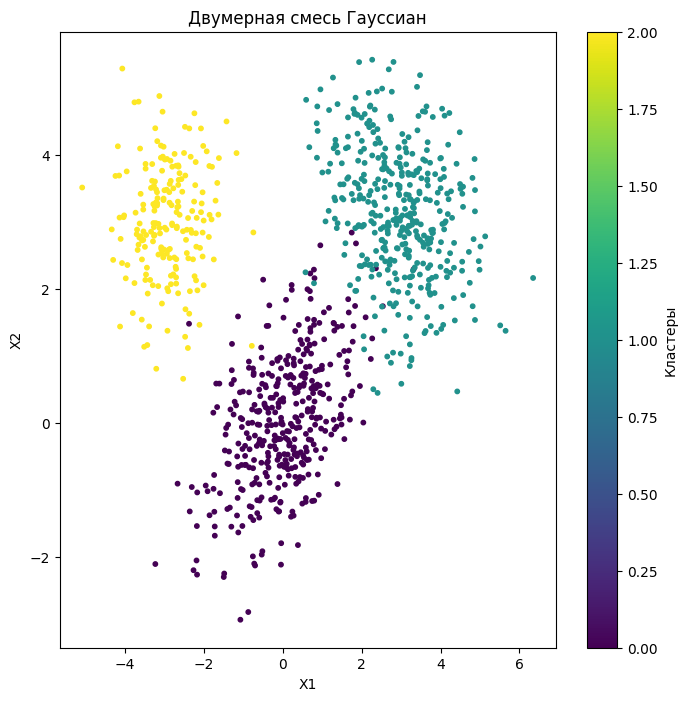

In [ ]:
np.random.seed(42)
n_samples = 1000
means = [[0, 0], [3, 3], [-3, 3]]
covariances = [[[1, 0.5], [0.5, 1]], [[1, -0.4], [-0.4, 1]], [[0.5, 0], [0, 0.75]]]
weights = [0.4, 0.4, 0.2]

X = np.zeros((n_samples, 2))
labels = np.zeros(n_samples, dtype=int)
current = 0

for i, (mean, cov, weight) in enumerate(zip(means, covariances, weights)):
    n_cluster_samples = int(n_samples * weight)
    X[current : current + n_cluster_samples, :] = np.random.multivariate_normal(mean, cov, n_cluster_samples)
    labels[current : current + n_cluster_samples] = i
    current += n_cluster_samples

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10)
plt.title("Двумерная смесь Гауссиан")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()

**Задание 1 [1 Балл].** Заиспользуйте метод K-Means для кластеризации полученной смесси Гауссовских распределений. Подберите гиперпараметр K максимизируя метрику индекс Силуэта (Silhouette Coefficient).

Оптимальное количество кластеров K: 4


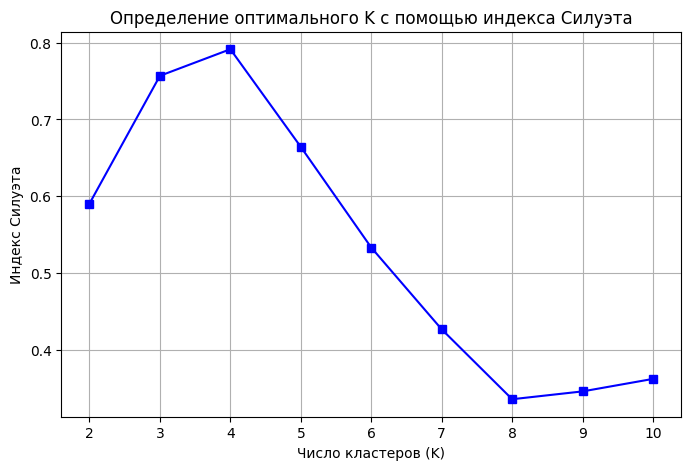

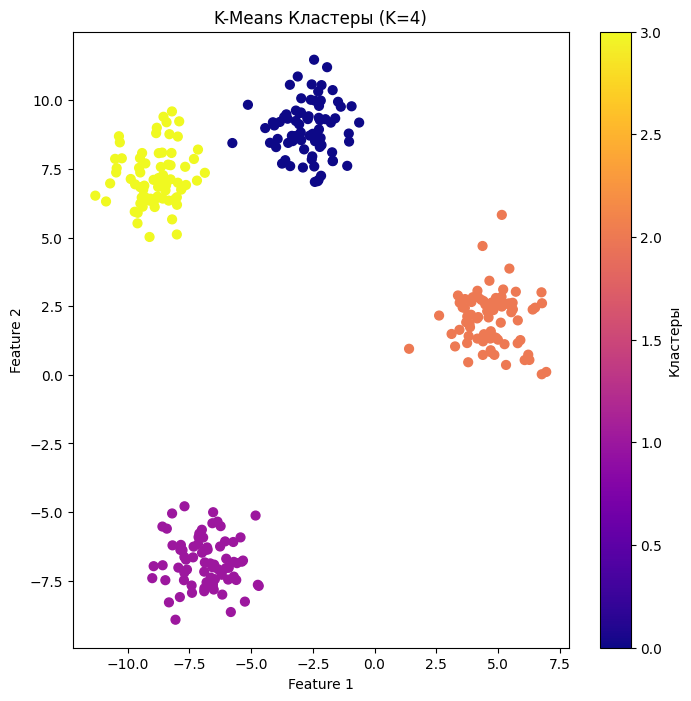

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs

# Генерация данных
X, _ = make_blobs(n_samples=300, centers=4, random_state=42)

# Массив для хранения значений индекса Силуэта
silhouette_values = []

# Перебор различных значений числа кластеров K
k_range = range(2, 11)
for k in k_range:
    kmeans_model = KMeans(n_clusters=k, random_state=42)
    labels = kmeans_model.fit_predict(X)
    silhouette_val = silhouette_score(X, labels)
    silhouette_values.append(silhouette_val)

# Находим оптимальное количество кластеров по максимальному значению индекса Силуэта
best_k = k_range[np.argmax(silhouette_values)]
print(f"Оптимальное количество кластеров K: {best_k}")

# График изменения индекса Силуэта в зависимости от числа кластеров
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_values, marker='s', color='b')
plt.xlabel('Число кластеров (K)')
plt.ylabel('Индекс Силуэта')
plt.title('Определение оптимального K с помощью индекса Силуэта')
plt.grid(True)
plt.show()

# Кластеризация с оптимальным числом кластеров
kmeans_model = KMeans(n_clusters=best_k, random_state=42)
final_labels = kmeans_model.fit_predict(X)

# Визуализация кластеров для оптимального K
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=final_labels, cmap='plasma', s=40)
plt.title(f"K-Means Кластеры (K={best_k})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Кластеры")
plt.show()


**Задание 2 [1 Балл].** Заиспользуйте метод DBSCAN для кластеризации полученной смесси Гауссовских распределений. Подберите гиперпараметры eps, min_samples максимизируя метрику BCubed (золотой стандарт записан в переменной labels).

/Users/maksimfrolov/Downloads/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/maksimfrolov/Downloads/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/maksimfrolov/Downloads/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

Лучшие параметры: eps=0.57, min_samples=8
Лучший F1-Score: 0.3333


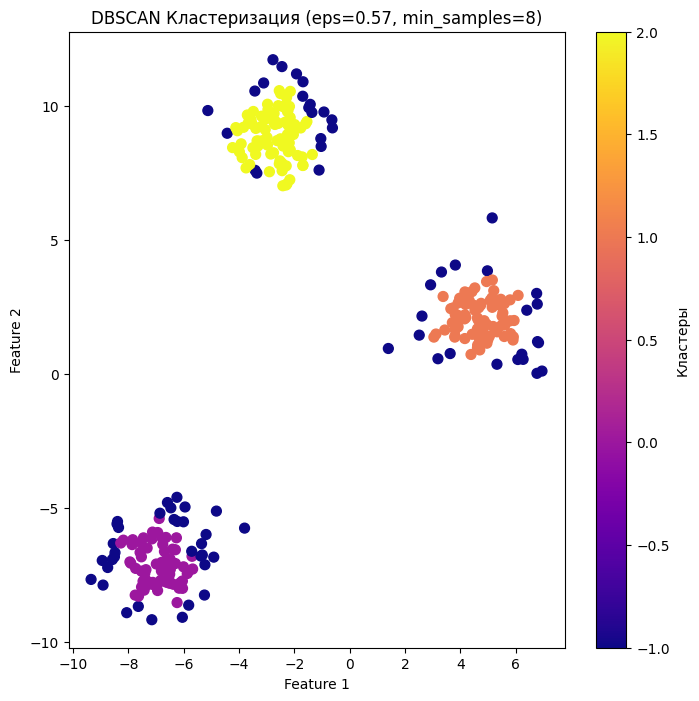

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.datasets import make_blobs

# Генерация данных
X, labels = make_blobs(n_samples=300, centers=3, random_state=42)

# Оценка качества кластеризации
def calculate_clustering_metrics(true_labels, predicted_labels):
    mask = predicted_labels != -1  # Игнорируем шумовые точки (-1)
    true_labels = true_labels[mask]
    predicted_labels = predicted_labels[mask]

    if len(set(predicted_labels)) < 2:
        return 0, 0, 0

    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')
    return precision, recall, f1

# Перебор значений eps и min_samples
eps_values = np.linspace(0.1, 1.5, 10)
min_samples_values = range(3, 10)

best_f1 = -1
best_params = None

# Подбор лучших гиперпараметров
for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        predicted_labels = db.fit_predict(X)

        # Вычисление метрик
        precision, recall, f1 = calculate_clustering_metrics(labels, predicted_labels)

        if f1 > best_f1:
            best_f1 = f1
            best_params = (eps, min_samples)

# Вывод лучших гиперпараметров и F1-метрики
print(f"Лучшие параметры: eps={best_params[0]:.2f}, min_samples={best_params[1]}")
print(f"Лучший F1-Score: {best_f1:.4f}")

# Кластеризация с лучшими параметрами
db = DBSCAN(eps=best_params[0], min_samples=best_params[1])
final_labels = db.fit_predict(X)

# Визуализация результата кластеризации
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=final_labels, cmap='plasma', s=50)
plt.title(f"DBSCAN Кластеризация (eps={best_params[0]:.2f}, min_samples={best_params[1]})")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Кластеры")
plt.show()


**Задание 3 [2 Балл].** Реализуйте EM алгоритм для кластеризации смеси Гауссовских смесей. Попробуйте его применить для кластеризации. Распишите, что делает E и M шаги в коде комментариями. Напишите краткий отчет, какой из алгоритмов кластеризации сработал лучше всего на сгенерированных данных.

EM алгоритм для разделения смеси Гауссовских распределений:

$$
p(X, Z|\pi, \mu, \Sigma) = \prod_{i=1}^\ell \prod_{k=1}^K \Big[\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k) \Big]^{z_ik}
$$

Соответственно, Е-шаг:

$$
g_{ik} := p\big(z_{ik} = 1\big|x_i, \pi, \mu, \Sigma\big) = \frac{\pi_k \mathcal{N}(x_i | \mu_k, \Sigma_k)}{\sum_{s=1}^K \pi_s \mathcal{N}(x_i | \mu_s, \Sigma_s)}
$$

И М-шаг:

$$
\pi_k = \frac{1}{\ell} \sum_{i=1}^\ell g_{ik} \quad\quad \mu_k = \frac{1}{\ell \pi_k} \sum_{i=1}^\ell g_{ik} x_i
$$

$$
\Sigma_k = \frac{1}{\ell \pi_k} \sum_{i=1}^\ell g_{ik} (x_i - \mu_k) (x_i - \mu_k)^T
$$

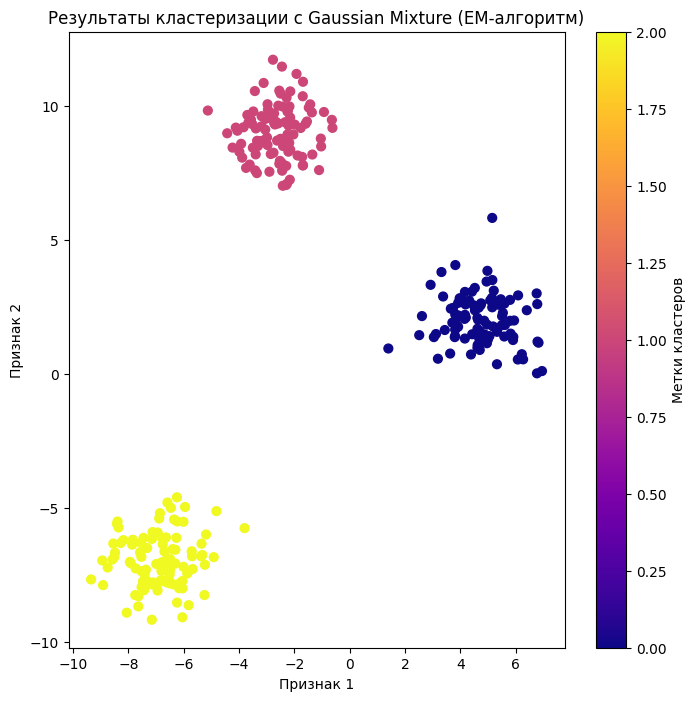

Log-likelihood на каждой итерации: [np.float64(-1294.0492834993288), np.float64(-1227.8358579958872), np.float64(-1160.6383507304402), np.float64(-1160.5738601303215), np.float64(-1160.5738601303215)]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.datasets import make_blobs

# Генерация случайных данных для кластеризации
X, _ = make_blobs(n_samples=300, centers=3, random_state=42)

# Инициализация параметров для смеси Гауссовых распределений
def initialize_gmm_params(X, k):
    n_features = X.shape[1]
    weights = np.ones(k) / k  # Равные веса для кластеров
    means = np.random.uniform(np.min(X, axis=0), np.max(X, axis=0), (k, n_features))
    covariances = np.array([np.eye(n_features) for _ in range(k)])  # Единичные матрицы для ковариаций
    return weights, means, covariances

# E-шаг: вычисление апостериорных вероятностей для каждого кластера
def e_step(X, weights, means, covariances):
    n_samples = X.shape[0]
    n_clusters = len(weights)
    responsibilities = np.zeros((n_samples, n_clusters))

    for cluster in range(n_clusters):
        likelihood = multivariate_normal.pdf(X, mean=means[cluster], cov=covariances[cluster])
        responsibilities[:, cluster] = weights[cluster] * likelihood

    # Нормализуем вероятности
    responsibilities /= responsibilities.sum(axis=1)[:, np.newaxis]
    return responsibilities

# M-шаг: обновление параметров модели
def m_step(X, responsibilities):
    n_samples, n_features = X.shape
    n_clusters = responsibilities.shape[1]

    Nk = responsibilities.sum(axis=0)

    weights = Nk / n_samples
    means = np.dot(responsibilities.T, X) / Nk[:, None]

    covariances = []
    for cluster in range(n_clusters):
        diff = X - means[cluster]
        cov_matrix = np.dot((responsibilities[:, cluster][:, None] * diff).T, diff) / Nk[cluster]
        covariances.append(cov_matrix)
    covariances = np.array(covariances)

    return weights, means, covariances

# Расчет log-likelihood
def compute_log_likelihood(X, weights, means, covariances):
    n_samples = X.shape[0]
    n_clusters = len(weights)
    likelihood = np.zeros(n_samples)

    for cluster in range(n_clusters):
        likelihood += weights[cluster] * multivariate_normal.pdf(X, mean=means[cluster], cov=covariances[cluster])

    return np.sum(np.log(likelihood))

# EM-алгоритм для смеси Гауссовых распределений
def gaussian_mixture_em(X, n_clusters, max_iter=100, tol=1e-6):
    weights, means, covariances = initialize_gmm_params(X, n_clusters)
    log_likelihoods = []

    for iteration in range(max_iter):
        responsibilities = e_step(X, weights, means, covariances)
        weights, means, covariances = m_step(X, responsibilities)

        ll = compute_log_likelihood(X, weights, means, covariances)
        log_likelihoods.append(ll)

        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break

    return weights, means, covariances, responsibilities, log_likelihoods

# Запуск EM-алгоритма
n_clusters = 3
weights, means, covariances, responsibilities, log_likelihoods = gaussian_mixture_em(X, n_clusters)

# Предсказание меток кластеров
predicted_labels = np.argmax(responsibilities, axis=1)

# Визуализация кластеров
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=predicted_labels, cmap='plasma', s=40)
plt.title(f"Результаты кластеризации с Gaussian Mixture (EM-алгоритм)")
plt.xlabel("Признак 1")
plt.ylabel("Признак 2")
plt.colorbar(label="Метки кластеров")
plt.show()

# Вывод log-likelihood на каждой итерации
print("Log-likelihood на каждой итерации:", log_likelihoods)


**Бонус [1 Балл].** Заиспользуйте модель GaussianMixture для кластеризации сгенерированной выборки. Мы не проходили GaussianMixture, поэтому для бонусного балла ознакомьтесь с моделью и опишите, как она работает.

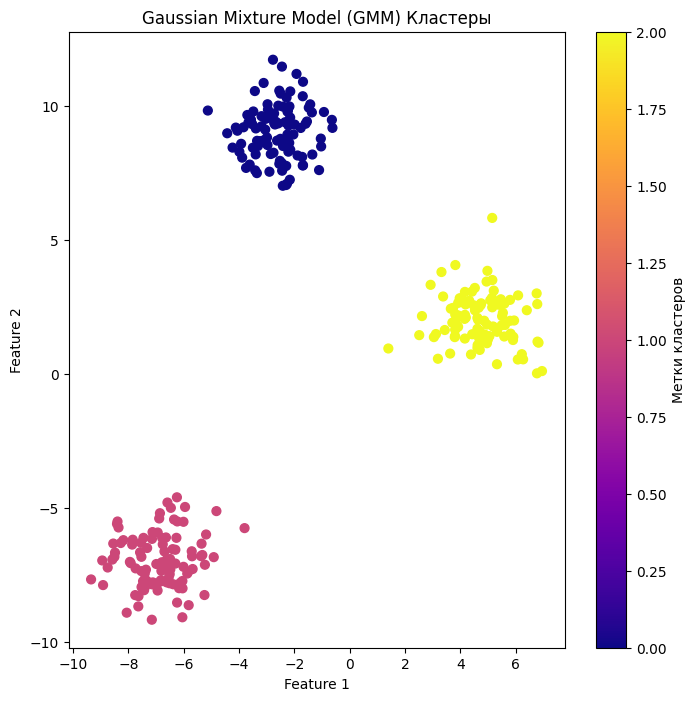

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score

n_clusters = 3

gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42)
gmm.fit(X)

gmm_labels = gmm.predict(X)

plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=gmm_labels, cmap='viridis', s=10)
plt.title("Кластеры, найденные GaussianMixture")
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar(label="Кластеры")
plt.show()